<a href="https://colab.research.google.com/github/trkfz2/M2020/blob/master/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import time
import copy
from PIL import Image
import os

# 1. Load Data

In [0]:
# The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])



In [0]:
# SVHN dataset

trainset = torchvision.datasets.SVHN(root='./data', split = 'train',
                                        download=True, transform=transform)

testset = torchvision.datasets.SVHN(root='./data', split = 'test',
                                       download=True, transform=transform)




In [0]:
print(type(trainset))
print(type(trainset).__mro__)


<class 'torchvision.datasets.svhn.SVHN'>
(<class 'torchvision.datasets.svhn.SVHN'>, <class 'torchvision.datasets.vision.VisionDataset'>, <class 'torch.utils.data.dataset.Dataset'>, <class 'object'>)


In [0]:
print(len(trainset))
print(len(testset))

73257
26032


In [0]:
dataset_sizes = dict()
dataset_sizes['train'] = len(trainset)
dataset_sizes['val'] = len(testset)

Show an image from the training set

Label:  2
Training images dimensions:  torch.Size([3, 32, 32])


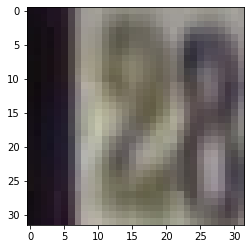

In [0]:
# function to show an image 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


img, label = trainset[12]

imshow(img)
print("Label: ", label)
print("Training images dimensions: ", img.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


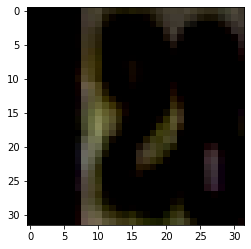

In [0]:
# show the normalized image
plt.imshow(img.permute(1,2,0))
plt.show()

### Data Loader

In [0]:
batch_size = 16

In [0]:
dataloader = dict()
dataloader['train'] = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
dataloader['val'] = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

## 2. Define a Convolutional Neural Network



In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2) 
        self.batch_norm1 = nn.BatchNorm2d(num_features = 32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) 
        self.batch_norm2 = nn.BatchNorm2d(num_features = 64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2) 
        self.batch_norm3 = nn.BatchNorm2d(num_features = 128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 10)

    def forward(self, x):
        out = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        out = self.pool2(F.relu(self.batch_norm2(self.conv2(out))))
        out = self.pool3(F.relu(self.batch_norm3(self.conv3(out))))
        out = out.view(-1, 128 * 4 * 4)
        out = self.fc1(out)
        return out


net = Net()

In [0]:
# initialize the weights of the convolutioanl layers with a normal distribution with std=0.001, and their biases with a constant value of 0
# default: Kaiming uniform initialization

def init_weights(m):
    if type(m) == nn.Conv2d:
        m.weight.data.normal_(0.0, 0.001)
        m.bias.data.fill_(0)

net.apply(init_weights)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)

# 3. Define a Loss function and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 4. Train the network




In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=10, bias=True)
)

In [0]:
######### TO DO: print
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model = train_model(net, criterion, optimizer, scheduler = exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.5684 Acc: 0.8276
val Loss: 0.4289 Acc: 0.8728

Epoch 1/9
----------
train Loss: 0.3454 Acc: 0.8993
val Loss: 0.3919 Acc: 0.8849

Epoch 2/9
----------
train Loss: 0.2830 Acc: 0.9182
val Loss: 0.3134 Acc: 0.9132

Epoch 3/9
----------
train Loss: 0.2437 Acc: 0.9312
val Loss: 0.3098 Acc: 0.9098

Epoch 4/9
----------
train Loss: 0.2144 Acc: 0.9397
val Loss: 0.2949 Acc: 0.9183

Epoch 5/9
----------
train Loss: 0.1866 Acc: 0.9485
val Loss: 0.3017 Acc: 0.9149

Epoch 6/9
----------
train Loss: 0.1643 Acc: 0.9542
val Loss: 0.2734 Acc: 0.9252

Epoch 7/9
----------
train Loss: 0.1029 Acc: 0.9759
val Loss: 0.2507 Acc: 0.9331

Epoch 8/9
----------
train Loss: 0.0916 Acc: 0.9798
val Loss: 0.2516 Acc: 0.9324

Epoch 9/9
----------
train Loss: 0.0847 Acc: 0.9819
val Loss: 0.2491 Acc: 0.9338

Training complete in 7m 23s
Best val Acc: 0.933774


In [0]:
# save trained model

PATH = './model1.pth'
torch.save(model.state_dict(), PATH)

GroundTruth:      5     2     1     0     6     1     9     1     1     8     3     6     5     1     4     4


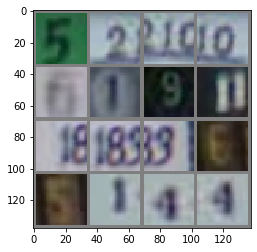

In [0]:
#display an image from the test set

dataiter = iter(dataloader['val'])
images, labels = dataiter.next()

# print images

imshow(torchvision.utils.make_grid(images, nrow = batch_size//4, padding = 2))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(batch_size)))

In [0]:
# load saved model

net_saved = Net()
net_saved.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [0]:
# test on sample test data

outputs = net_saved(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j].item()
                              for j in range(batch_size)))

Predicted:      5     2     1     0     6     1     9     1     1     8     9     6     5     1     4     4


In [0]:
# test on the whole test set

correct = 0
total = 0
with torch.no_grad():
    for data in dataloader['val']:
        images, labels = data
        outputs = net_saved(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 93 %


## Tuning experiments

In [0]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


model2 = train_model(net, criterion, optimizer, scheduler = exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0300 Acc: 0.9958
val Loss: 0.2767 Acc: 0.9294

Epoch 1/9
----------
train Loss: 0.0297 Acc: 0.9960
val Loss: 0.2780 Acc: 0.9296

Epoch 2/9
----------
train Loss: 0.0293 Acc: 0.9961
val Loss: 0.2778 Acc: 0.9295

Epoch 3/9
----------
train Loss: 0.0289 Acc: 0.9960
val Loss: 0.2772 Acc: 0.9297

Epoch 4/9
----------
train Loss: 0.0287 Acc: 0.9963
val Loss: 0.2792 Acc: 0.9295

Epoch 5/9
----------
train Loss: 0.0289 Acc: 0.9963
val Loss: 0.2777 Acc: 0.9291

Epoch 6/9
----------
train Loss: 0.0285 Acc: 0.9961
val Loss: 0.2781 Acc: 0.9292

Epoch 7/9
----------
train Loss: 0.0285 Acc: 0.9963
val Loss: 0.2824 Acc: 0.9298

Epoch 8/9
----------
train Loss: 0.0285 Acc: 0.9962
val Loss: 0.2786 Acc: 0.9290

Epoch 9/9
----------
train Loss: 0.0287 Acc: 0.9962
val Loss: 0.2802 Acc: 0.9291

Training complete in 6m 35s
Best val Acc: 0.929817


In [0]:
learning_rate = 1e-4

optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False) 

#Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


model3 = train_model(net, criterion, optimizer, scheduler = exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0731 Acc: 0.9801
val Loss: 0.3331 Acc: 0.9151

Epoch 1/9
----------
train Loss: 0.0623 Acc: 0.9834
val Loss: 0.3265 Acc: 0.9203

Epoch 2/9
----------
train Loss: 0.0556 Acc: 0.9852
val Loss: 0.3196 Acc: 0.9224

Epoch 3/9
----------
train Loss: 0.0256 Acc: 0.9960
val Loss: 0.2965 Acc: 0.9281

Epoch 4/9
----------
train Loss: 0.0189 Acc: 0.9979
val Loss: 0.3013 Acc: 0.9266

Epoch 5/9
----------
train Loss: 0.0164 Acc: 0.9982
val Loss: 0.3046 Acc: 0.9276

Epoch 6/9
----------
train Loss: 0.0131 Acc: 0.9991
val Loss: 0.2983 Acc: 0.9284

Epoch 7/9
----------
train Loss: 0.0128 Acc: 0.9991
val Loss: 0.3005 Acc: 0.9281

Epoch 8/9
----------
train Loss: 0.0125 Acc: 0.9991
val Loss: 0.3057 Acc: 0.9281

Epoch 9/9
----------
train Loss: 0.0122 Acc: 0.9993
val Loss: 0.3016 Acc: 0.9278

Training complete in 6m 40s
Best val Acc: 0.928434


In [0]:
# smaller kernels, add one conv layer

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2) 
        self.batch_norm1 = nn.BatchNorm2d(num_features = 32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2) 
        self.batch_norm2 = nn.BatchNorm2d(num_features = 64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) 
        self.batch_norm3 = nn.BatchNorm2d(num_features = 128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1) 
        self.batch_norm4 = nn.BatchNorm2d(num_features = 256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 10)

    def forward(self, x):
        out = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
        out = self.pool2(F.relu(self.batch_norm2(self.conv2(out))))
        out = self.pool3(F.relu(self.batch_norm3(self.conv3(out))))
        out = self.pool4(F.relu(self.batch_norm4(self.conv4(out))))
        out = out.view(-1, 256 * 2 * 2)
        out = self.fc1(out)
        return out


net2 = Net2()


In [0]:
# initialize the weights of the convolutioanl layers with a normal distribution with std=0.001, and their biases with a constant value of 0
# default: Kaiming uniform initialization

def init_weights(m):
    if type(m) == nn.Conv2d:
        m.weight.data.normal_(0.0, 0.001)
        m.bias.data.fill_(0)

In [0]:
net2.apply(init_weights)

Net2(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, 

In [0]:
net2.to(device)

Net2(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, 

In [0]:
criterion = nn.CrossEntropyLoss()

#learning_rate = 1e-4
learning_rate = 1e-3

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False) 

#Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


model4 = train_model(net2, criterion, optimizer, scheduler = exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 2.3814 Acc: 0.1038
val Loss: 2.3776 Acc: 0.1093

Epoch 1/4
----------
train Loss: 2.3818 Acc: 0.1027
val Loss: 2.3774 Acc: 0.1097

Epoch 2/4
----------
train Loss: 2.3813 Acc: 0.1028
val Loss: 2.3704 Acc: 0.1105

Epoch 3/4
----------
train Loss: 2.3806 Acc: 0.1039
val Loss: 2.3751 Acc: 0.1102

Epoch 4/4
----------
train Loss: 2.3806 Acc: 0.1048
val Loss: 2.3791 Acc: 0.1083

Training complete in 3m 52s
Best val Acc: 0.110518


# 6. Custom Dataset and Transforms

In [0]:
class SVHNDataset(Dataset):
    """SVHN dataset."""

    def __init__(self, root, split = 'train', transform=None):
        """
        Args:
            root (string): Directory with all the images.
            split (string):  'train' or 'test' set
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root = root
        self.train = loadmat(os.path.join(self.root, 'train_32x32.mat'))
        self.test = loadmat(os.path.join(self.root, 'test_32x32.mat'))
        self.split = split
        self.transform = transform
        
        # replace label 10 with label
        self.train['y'][self.train['y']==10] = 0
        self.test['y'][self.test['y']==10] = 0

    def __len__(self):
        if (self.split == 'train'):
          return self.train['y'].shape[0]
        elif(self.split == 'test'):
          return self.test['y'].shape[0]

    def __getitem__(self, idx): 
        if (self.split == 'train'):
          image = self.train['X'][:,:,:,idx]
          label = self.train['y'][idx,:]
        elif(self.split == 'test'):
          image = self.test['X'][:,:,:,idx]
          label = self.test['y'][idx,:]

        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'label': label}

In [0]:
transform_custom = transforms.Compose(
    [ToTensor()])

In [0]:
# does not work
# TypeError: tensor is not a torch image

#transform_custom = transforms.Compose(
#    [ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#    ])



In [0]:
trainset_custom = SVHNDataset(root='./data', split= 'train', transform = transform_custom)
testset_custom = SVHNDataset(root='./data', split= 'test', transform = transform_custom)

In [0]:
print(len(trainset_custom))
print(len(testset_custom))

73257
26032


In [0]:
print(type(trainset_custom))
print(type(trainset_custom).__mro__)

<class '__main__.SVHNDataset'>
(<class '__main__.SVHNDataset'>, <class 'torch.utils.data.dataset.Dataset'>, <class 'object'>)


In [0]:
print(type(trainset_custom[8]['image']))
print(type(trainset_custom[8]['label']))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
